In [1]:
import numpy as np
import pandas as pd
import os
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from collections import OrderedDict

In [2]:
from platform import python_version
print(python_version())

3.6.6


### Create edgelist using events data

In [3]:
event_file = [item for item in os.listdir('../../data/protag_events_v2/') if 'txt' in item]

In [4]:
events_all = []
cnt = 0
for name in event_file:
    movie_events = []
    with open(os.path.join('../../data/protag_events_v2/', name), 'r') as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            line = line.split(' ')
            movie_events.append(line[1].split('-')[0])
        events_all.append(movie_events)


In [5]:
len(events_all)

13362

In [9]:
events_all[0:2]

[['build', 'appear', 'appear', 'escape', 'escape', 'get', 'other_cos', 'dub'],
 ['escape',
  'obtain',
  'confront',
  'cope',
  'fend',
  'meet',
  'battle',
  'appear',
  'escape',
  'cope',
  'seem',
  'dress',
  'enforce',
  'obtain']]

In [10]:
edgelist = []
for movie_event in events_all:
    for i in range(len(movie_event)-1):
        edgelist.append((movie_event[i], movie_event[i+1]))

In [11]:
c = Counter(edgelist)

In [12]:
c.most_common(20)

[(('involve', 'admit'), 1054),
 (('admit', 'involve'), 1047),
 (('amuse', 'amuse'), 779),
 (('get', 'get'), 735),
 (('admit', 'admit'), 585),
 (('escape', 'get'), 559),
 (('escape', 'escape'), 523),
 (('amuse', 'get'), 503),
 (('get', 'amuse'), 481),
 (('amuse', 'escape'), 423),
 (('own', 'own'), 410),
 (('escape', 'amuse'), 406),
 (('escape', 'discover'), 402),
 (('get', 'discover'), 401),
 (('discover', 'discover'), 390),
 (('get', 'escape'), 389),
 (('discover', 'get'), 386),
 (('discover', 'amuse'), 359),
 (('amuse', 'discover'), 342),
 (('become', 'become'), 339)]

In [13]:
edgelist_wtd = []
for item in edgelist:
    if c[item] > 1:
        edge = (item[0], item[1], c[item])
        edgelist_wtd.append(edge)

In [14]:
edgelist_wtd[0:5]

[('build', 'appear', 14),
 ('appear', 'appear', 147),
 ('appear', 'escape', 138),
 ('escape', 'escape', 523),
 ('escape', 'get', 559)]

### Build network

In [16]:
G = nx.DiGraph()

In [17]:
G.add_weighted_edges_from(edgelist_wtd)

In [21]:
G.number_of_nodes()

409

In [22]:
G.number_of_edges()

17952

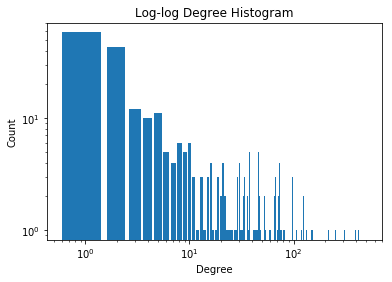

In [18]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt)

plt.title("Log-log Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.xscale('log')
plt.yscale('log')
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)

In [17]:
nx.write_gml(G, 'event_network.gml')

In [109]:
def compute_p(G, weight='weight', p='p'):
    # Undirected
    for node in G:
        k_n = len(G[node])
        if k_n > 1:
            sum_w = sum( G[node][neighbor][weight] for neighbor in G[node] )
            for neighbor in G[node]:
                edge_weight = G[node][neighbor][weight]
                p_ij = float(edge_weight)/sum_w
                G[node][neighbor][p] = (1-p_ij)**(k_n-1)
    return G

def alpha_cut(G, alpha, p='p'):
    C = G.copy()
    for u,v,d in G.edges.data():
        if 'p' in d.keys():
            if d['p'] < alpha:
                C.remove_edge(u,v)
    return C

In [113]:
G_c = compute_p(G)

In [119]:
C = alpha_cut(G, 0.8, 'p')

In [120]:
C.number_of_edges()

1815

In [121]:
C.number_of_nodes()

409

In [123]:
nx.write_gml(C, 'event_network.gml')

In [124]:
nx.__version__

'2.2'

### Event transitions

In [206]:
df = pd.DataFrame.from_records(edgelist_wtd, columns = ['src', 'des', 'weight'])

In [207]:
df.head(2)

,src,des,weight
0,build,appear,14
1,appear,appear,147


In [208]:
# Compute Size of Each event as source (# of Transitions Out)
s_src = df.groupby('src', as_index=False).agg({'weight': np.sum})
s_src.columns = ['src_event', 'size']

In [209]:
s_src.head(2)

,src_event,size
0,abort,12
1,absorb,53


In [210]:
# Compute Size of Each event as destination (# of Transitions in)
s_des = df.groupby('des', as_index=False).agg({'weight': np.sum})
s_des.columns = ['des_event', 'size']

In [211]:
s_des.head(2)

,des_event,size
0,abort,4
1,abscond,9


In [212]:
expected = pd.merge(df, s_src, left_on='src', right_on = 'src_event')

In [213]:
expected.head(2)

,src,des,weight,src_event,size
0,build,appear,14,build,9842
1,build,escape,31,build,9842


In [214]:
expected = pd.merge(expected, s_des, left_on='des', right_on='des_event', suffixes=['_src', '_des'])

In [216]:
expected = expected.drop_duplicates()

In [217]:
len(expected)

21715

In [218]:
# Calculate normalized weights
expected['exp'] = expected['size_src']*expected['size_des']/sum(expected['size_des'])
expected['normed_weight'] = expected['weight']/expected['exp']
expected = expected[['src', 'des', 'normed_weight']]

In [219]:
expected.head(2)

,src,des,normed_weight
0,build,appear,30.797193
14,appear,appear,15.971760


### Hierarchical clustering

In [220]:
df = expected.drop_duplicates().pivot(index="src", columns="des", values='normed_weight')
df.fillna(1.0, inplace=True)
df = np.log(df)

In [221]:
df.head()

des,abort,abscond,absorb,accept,accompany,accost,acquiesce,addict,adjust,admire,...,want,weather,wink,wipe_instr,wipe_manner,wish,withdraw,withhold,wreak,|
src,,,,,,,,,,,,,,,,,,,,,
abort,18.825216,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0
absorb,0.000000,0.0,16.241219,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0
accept,0.000000,0.0,0.000000,5.9304,6.557704,0.0,0.0,0.0,0.0,3.584337,...,3.468875,0.0,0.0,0.0,5.56566,0.00000,0.0,0.0,0.0,0.0
accompany,0.000000,0.0,0.000000,0.0000,8.768064,0.0,0.0,0.0,0.0,4.831886,...,0.000000,0.0,0.0,0.0,0.00000,5.19597,0.0,0.0,0.0,0.0
accost,0.000000,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0


In [222]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import seaborn as sns


In [223]:

method = 'average'
metric = 'euclidean'
Z = hierarchy.linkage(df, method=method, metric=metric)
# c, coph_dists = hierarchy.cophenet(Z, pdist(df))
# part = hierarchy.fclusterdata(Z,1.5)

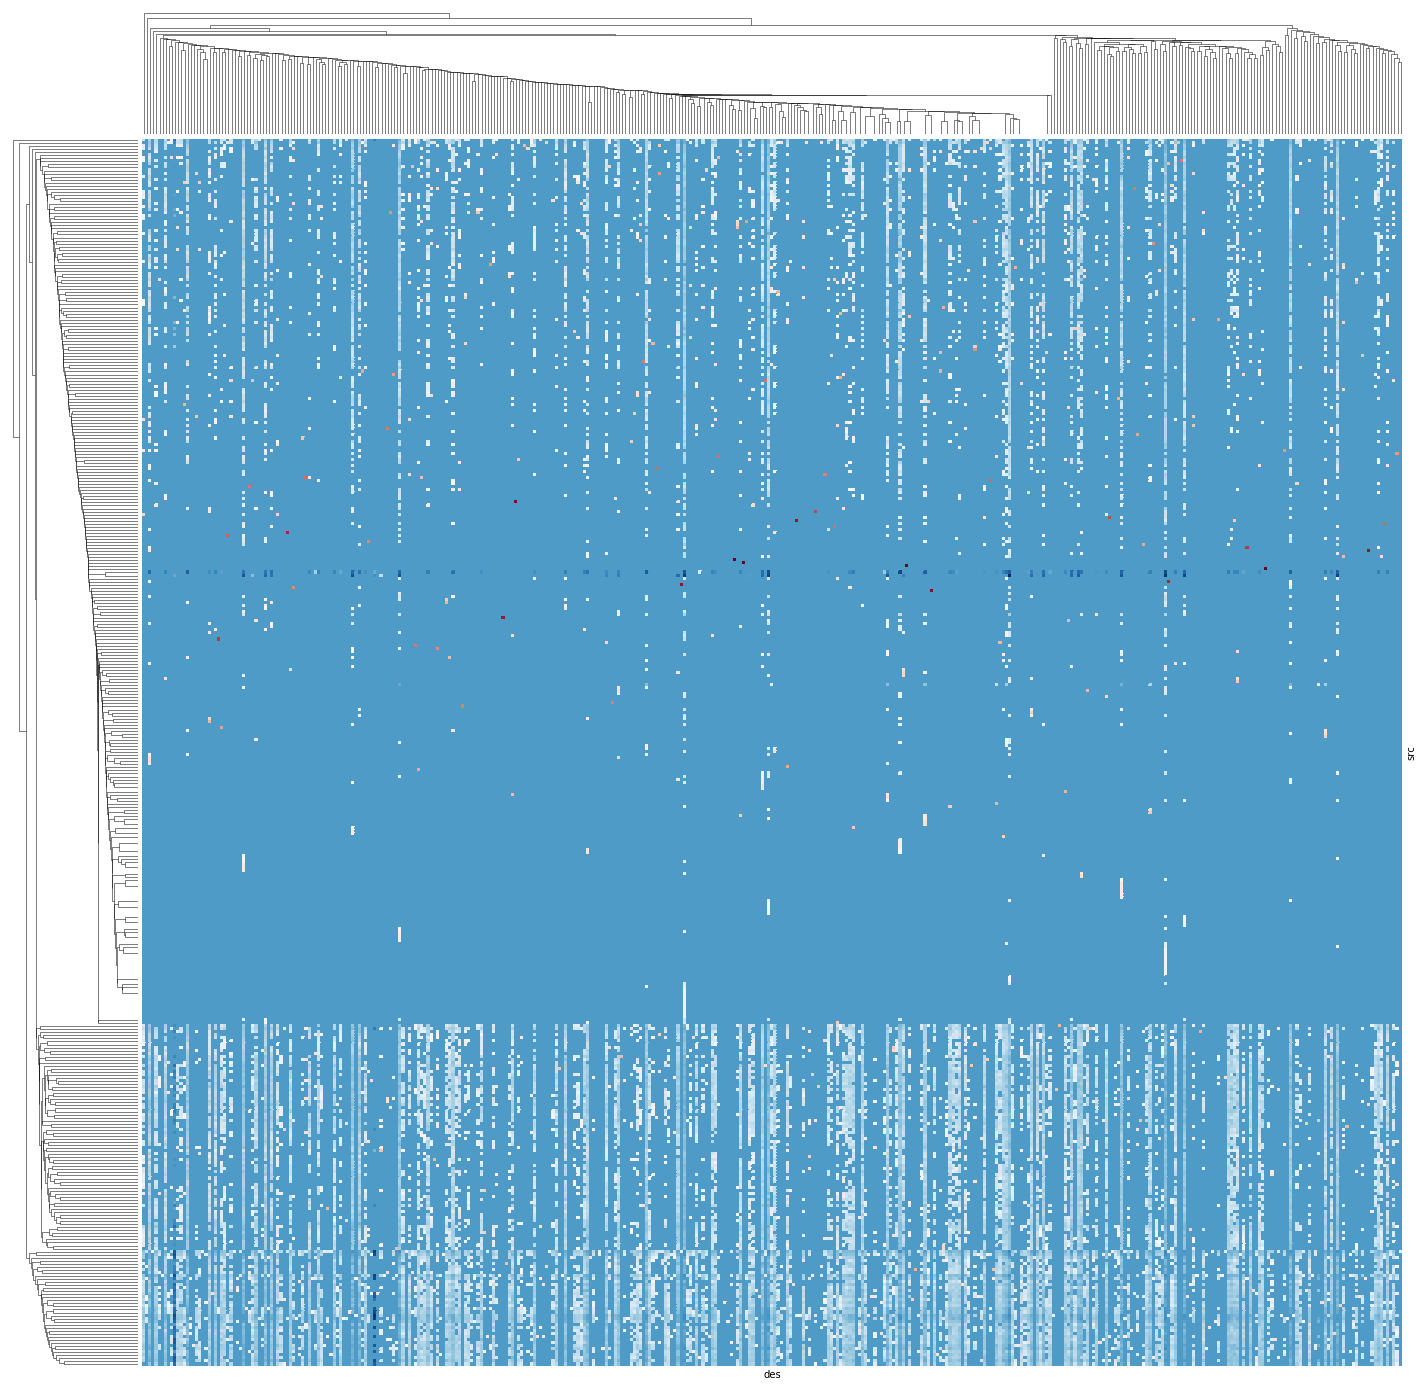

In [224]:
cm = sns.clustermap(df,figsize=(25, 25),row_linkage=Z, col_linkage=Z, cmap = "RdBu_r", xticklabels = False, yticklabels = False)
cm.cax.set_visible(False)

